#### Author
Yury Kashnitsky

#### Reference
[Notion ticket](https://www.notion.so/Fear-Greed-Index-2f3b24a5a63641588b5fc36e7e47d063)

#### Idea
Explore correlation between average predicted daily positive sentiment and BTC price

#### Data

 - `../data/model_predictions_export_20221003.csv` – exported model predictions, May 6th - Nov 3rd, [source](https://drive.google.com/drive/folders/1DKCpRo0NT3GKURlJy935ktN37NARUR41?usp=share_link)
 - `'../data/news_titles_export_20221003.csv'` –  – exported news metadata, May 6th - Nov 3rd, [source](https://drive.google.com/drive/folders/1DKCpRo0NT3GKURlJy935ktN37NARUR41?usp=share_link)
 - BTC daily price data from [Investing.com](https://www.investing.com/crypto/bitcoin/historical-data)


#### Result

No reasonable correlation found for our Cryptobarometer. Fear & Greed Index is much better.

In [1]:
import pandas as pd
from datetime import datetime

from scipy.stats import pearsonr 
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

## Our parsed news title with predicted sentiments

In [2]:
model_pred_df = pd.read_csv('../data/model_predictions_export_20221003.csv', index_col='title_id')
news_titles_df = pd.read_csv('../data/news_titles_export_20221003.csv', index_col='title_id', parse_dates=['pub_time'])

In [3]:
model_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19346 entries, 1419644163 to 162912651
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   negative         19346 non-null  float64
 1   neutral          19346 non-null  float64
 2   positive         19346 non-null  float64
 3   predicted_class  19346 non-null  int64  
 4   is_annotating    19346 non-null  bool   
dtypes: bool(1), float64(3), int64(1)
memory usage: 774.6 KB


In [4]:
news_titles_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 19346 entries, 622697109.0 to -1690028872.0
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     19346 non-null  object        
 1   source    19346 non-null  object        
 2   pub_time  19346 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 604.6+ KB


In [5]:
news_titles_df.head()

,title,source,pub_time
title_id,,,
6.226971e+08,Long-Term BTC Holders Begin Distribution Prece...,https://www.dcforecasts.com/feed/,2022-06-05 16:47:10
-1.211327e+09,China Lashed Out At Xinjiang’s Park For Introd...,https://www.dcforecasts.com/feed/,2022-06-05 16:39:54
2.074265e+09,Crypto Market Cap Loses $100B In 3 Days As BTC...,https://www.dcforecasts.com/feed/,2022-06-05 15:21:19
-3.109619e+08,Bermuda Targets To Become A Digital Asset Hub ...,https://www.dcforecasts.com/feed/,2022-06-05 12:04:38
-9.413652e+08,"Cardano Consolidates At $0.56, Nearing Crucial...",https://www.dcforecasts.com/feed/,2022-06-05 11:51:54


In [6]:
model_pred_df.head()

,negative,neutral,positive,predicted_class,is_annotating
title_id,,,,,
1419644163,0.008595,0.012925,0.978480,2,True
1593123919,0.004479,0.017847,0.977673,2,True
-1026958932,0.004789,0.009721,0.985490,2,False
-617894431,0.980306,0.009738,0.009956,0,True
-1662033928,0.002679,0.017072,0.980249,2,True


In [7]:
news_titles_with_preds_df = news_titles_df.join(model_pred_df, on='title_id', lsuffix='_left')

In [8]:
news_titles_with_preds_df['pub_time'].min(), news_titles_with_preds_df['pub_time'].max()

(Timestamp('2022-05-06 14:10:00'), Timestamp('2022-11-03 11:57:05'))

In [9]:
news_titles_with_preds_df['pub_date'] = news_titles_with_preds_df['pub_time'].apply(lambda ts: pd.to_datetime(ts.date()))

In [10]:
news_titles_with_preds_df.head(2)

,title,source,pub_time,negative,neutral,positive,predicted_class,is_annotating,pub_date
title_id,,,,,,,,,
6.226971e+08,Long-Term BTC Holders Begin Distribution Prece...,https://www.dcforecasts.com/feed/,2022-06-05 16:47:10,0.012220,0.12109,0.866690,2,True,2022-06-05
-1.211327e+09,China Lashed Out At Xinjiang’s Park For Introd...,https://www.dcforecasts.com/feed/,2022-06-05 16:39:54,0.081629,0.44483,0.473541,2,True,2022-06-05


## Fear & Greed Index

In [11]:
fear_greed_df = pd.read_csv('../data/20221108_fear_greed_index_from_06052022_to_03112022.csv')

In [12]:
fear_greed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   date                182 non-null    object
 1   fng_value           182 non-null    int64 
 2   fng_classification  182 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.4+ KB


In [13]:
fear_greed_df['date'] = fear_greed_df['date'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y'))

In [14]:
fear_greed_df = fear_greed_df.sort_values(by='date')

In [15]:
fear_greed_df.head()

,date,fng_value,fng_classification
181,2022-05-06,22,Extreme Fear
180,2022-05-07,23,Extreme Fear
179,2022-05-08,18,Extreme Fear
178,2022-05-09,11,Extreme Fear
177,2022-05-10,10,Extreme Fear


In [16]:
fng_scaler = MinMaxScaler()
fear_greed_df['fng_value_normed'] = fng_scaler.fit_transform(fear_greed_df['fng_value'].values.reshape(-1, 1))

## BTC data for the same period

In [17]:
btc_price_df = pd.read_csv('../data/Bitcoin_Historical_Data_investing_com_may22_nov22.csv', parse_dates=['Date'])

In [18]:
btc_price_df['Price'] = btc_price_df['Price'].apply(lambda x: float(x.replace(',', '')))

In [19]:
scaler = MinMaxScaler()

In [20]:
btc_price_df['Price_normed'] = scaler.fit_transform(btc_price_df['Price'].values.reshape(-1, 1))

In [21]:
btc_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          182 non-null    datetime64[ns]
 1   Price         182 non-null    float64       
 2   Open          182 non-null    object        
 3   High          182 non-null    object        
 4   Low           182 non-null    object        
 5   Vol.          182 non-null    object        
 6   Change %      182 non-null    object        
 7   Price_normed  182 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 11.5+ KB


In [22]:
btc_price_df['Date'].min(), btc_price_df['Date'].max()

(Timestamp('2022-05-06 00:00:00'), Timestamp('2022-11-03 00:00:00'))

In [23]:
btc_price_df.sort_values(by='Date').head()

,Date,Price,Open,High,Low,Vol.,Change %,Price_normed
181,2022-05-06,36009.0,"36,540.0","36,646.0","35,267.0",752.84M,-1.46%,1.000000
180,2022-05-07,35468.0,"36,003.0","36,119.0","34,773.0",288.86M,-1.50%,0.969121
179,2022-05-08,34060.0,"35,468.0","35,497.0","33,727.0",671.05M,-3.97%,0.888756
178,2022-05-09,30095.0,"34,041.0","34,227.0","30,095.0",268.09K,-11.64%,0.662443
177,2022-05-10,31007.5,"30,098.2","32,621.2","29,831.0",235.61K,3.03%,0.714526


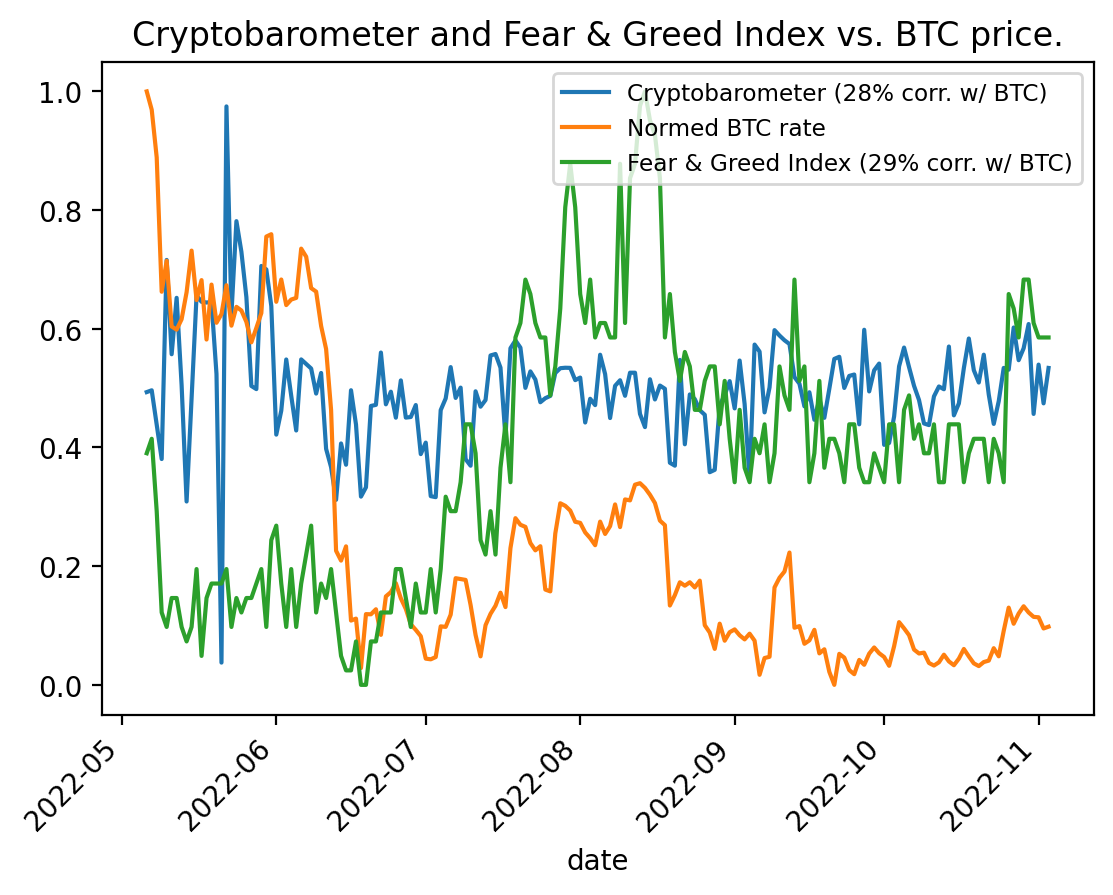

In [24]:
news_titles_with_preds_df.groupby('pub_date')['positive'].mean().plot(label='Cryptobarometer (28% corr. w/ BTC)')
btc_price_df.groupby('Date')['Price_normed'].mean().plot(label='Normed BTC rate');
fear_greed_df.groupby('date')['fng_value_normed'].mean().plot(label='Fear & Greed Index (29% corr. w/ BTC)');
plt.xticks(rotation = 45); # Rotates X-Axis Ticks by 45-degrees
plt.legend(loc='best', fontsize='small', fancybox=True);
plt.title('Cryptobarometer and Fear & Greed Index vs. BTC price.');

In [25]:
pearsonr(news_titles_with_preds_df.groupby('pub_date')['positive'].mean(),
         btc_price_df.loc[btc_price_df['Date'].isin(news_titles_with_preds_df['pub_date'])].groupby('Date')['Price_normed'].mean())

PearsonRResult(statistic=0.27867378604104565, pvalue=0.00015848230850879698)

In [26]:
pearsonr(fear_greed_df.groupby('date')['fng_value_normed'].mean(),
         btc_price_df.groupby('Date')['Price_normed'].mean())

PearsonRResult(statistic=-0.28632918651137307, pvalue=8.908694946909398e-05)

In [27]:
pearsonr(news_titles_with_preds_df.groupby('pub_date')['positive'].mean(),
         fear_greed_df.loc[fear_greed_df['date'].isin(news_titles_with_preds_df['pub_date'])].groupby('date')['fng_value_normed'].mean())

PearsonRResult(statistic=0.01963403394445639, pvalue=0.7941925258514296)

Last 3 months

In [28]:
news_titles_preds_last_3months = news_titles_with_preds_df.loc[news_titles_with_preds_df['pub_date'] >= '2022-07-01']
fear_greed_df_last_3months = fear_greed_df.loc[fear_greed_df['date'] >= '2022-07-01']
btc_price_df_last_3months = btc_price_df.loc[btc_price_df['Date'] >= '2022-07-01']

In [29]:
%%capture
btc_price_df_last_3months['Price_normed'] = scaler.fit_transform(btc_price_df_last_3months['Price'].values.reshape(-1, 1))
fear_greed_df_last_3months['fng_value_normed'] = fng_scaler.fit_transform(fear_greed_df_last_3months['fng_value'].values.reshape(-1, 1))

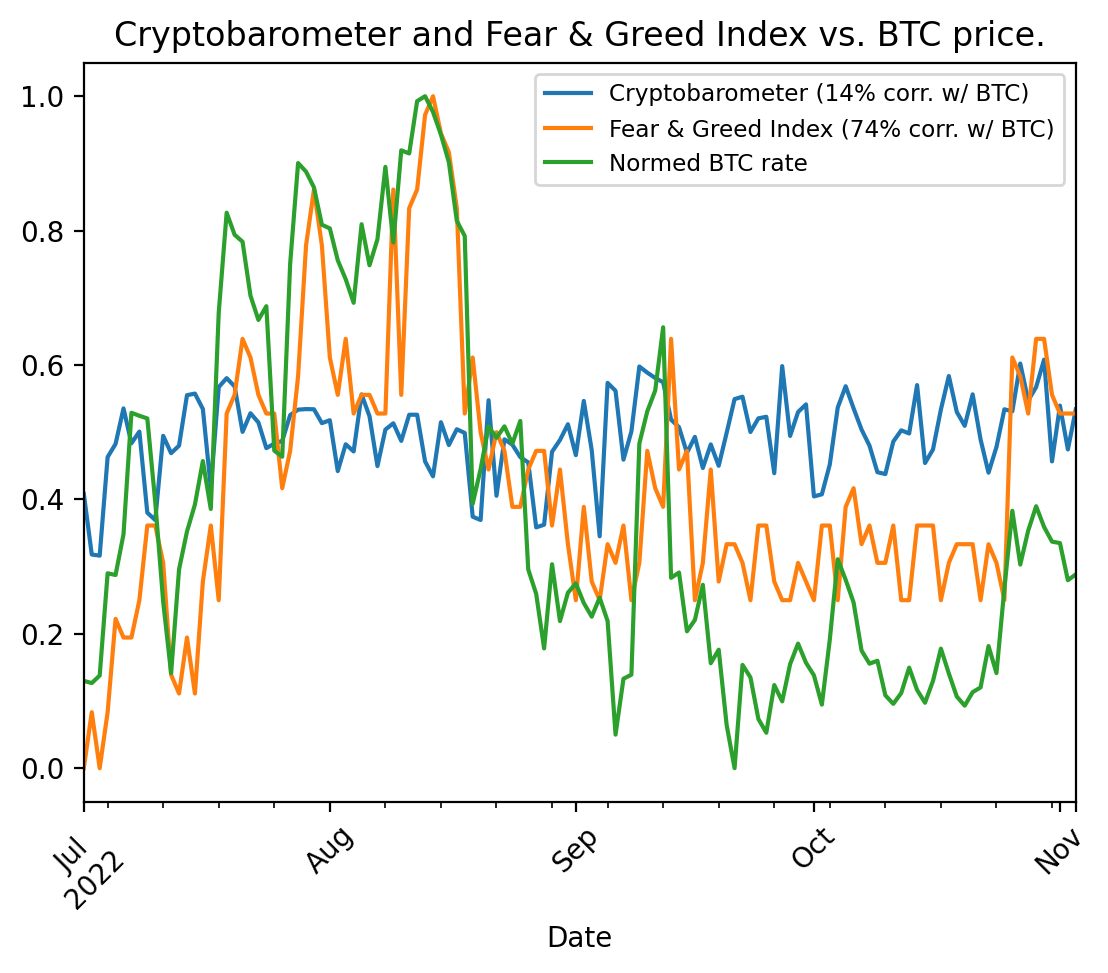

In [30]:
news_titles_preds_last_3months.groupby('pub_date')['positive'].mean().plot(label='Cryptobarometer (14% corr. w/ BTC)')
fear_greed_df_last_3months.groupby('date')['fng_value_normed'].mean().plot(label='Fear & Greed Index (74% corr. w/ BTC)');
btc_price_df_last_3months.groupby('Date')['Price_normed'].mean().plot(label='Normed BTC rate');
plt.xticks(rotation = 45); # Rotates X-Axis Ticks by 45-degrees
plt.title('Cryptobarometer and Fear & Greed Index vs. BTC price.');
plt.legend(loc='best', fontsize='small', fancybox=True);

In [31]:
pearsonr(news_titles_preds_last_3months.groupby('pub_date')['positive'].mean(),
         btc_price_df_last_3months.groupby('Date')['Price_normed'].mean())

PearsonRResult(statistic=0.14135658686231284, pvalue=0.11437073225730093)

In [32]:
pearsonr(fear_greed_df_last_3months.groupby('date')['fng_value_normed'].mean(),
         btc_price_df_last_3months.groupby('Date')['Price_normed'].mean())

PearsonRResult(statistic=0.7358327264577911, pvalue=9.787889624144166e-23)

Last month

In [33]:
news_titles_preds_last_month = news_titles_with_preds_df.loc[news_titles_with_preds_df['pub_date'] >= '2022-10-01']
fear_greed_df_last_month = fear_greed_df.loc[fear_greed_df['date'] >= '2022-10-01']
btc_price_df_last_month = btc_price_df.loc[btc_price_df['Date'] >= '2022-10-01']

In [34]:
%%capture
btc_price_df_last_month['Price_normed'] = scaler.fit_transform(btc_price_df_last_month['Price'].values.reshape(-1, 1))
fear_greed_df_last_month['fng_value_normed'] = fng_scaler.fit_transform(fear_greed_df_last_month['fng_value'].values.reshape(-1, 1))

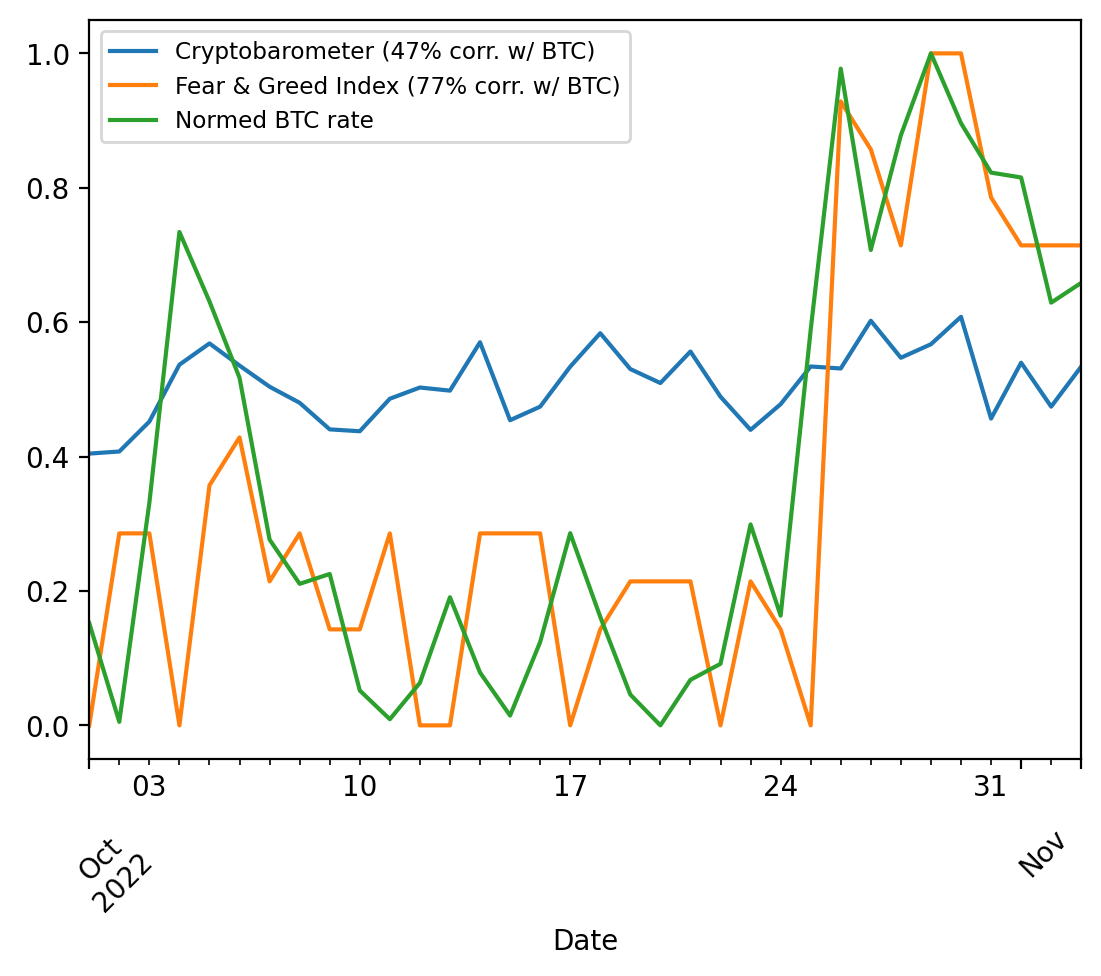

In [35]:
news_titles_preds_last_month.groupby('pub_date')['positive'].mean().plot(label='Cryptobarometer (47% corr. w/ BTC)')
fear_greed_df_last_month.groupby('date')['fng_value_normed'].mean().plot(label='Fear & Greed Index (77% corr. w/ BTC)');
btc_price_df_last_month.groupby('Date')['Price_normed'].mean().plot(label='Normed BTC rate');
plt.xticks(rotation = 45); # Rotates X-Axis Ticks by 45-degrees
plt.legend(loc='best', fontsize='small', fancybox=True);


In [36]:
pearsonr(news_titles_preds_last_month.groupby('pub_date')['positive'].mean(),
         btc_price_df_last_month.groupby('Date')['Price_normed'].mean())

PearsonRResult(statistic=0.474593266246817, pvalue=0.0045691576849732525)

In [37]:
pearsonr(fear_greed_df_last_month.groupby('date')['fng_value_normed'].mean(),
         btc_price_df_last_month.groupby('Date')['Price_normed'].mean())

PearsonRResult(statistic=0.7678307621969495, pvalue=1.1591284321306336e-07)

In [38]:
pearsonr(news_titles_preds_last_month.groupby('pub_date')['positive'].mean(),
         fear_greed_df_last_month.groupby('date')['fng_value_normed'].mean())

PearsonRResult(statistic=0.3979098767859356, pvalue=0.019775845055759488)